# Projects

Wells are one of the fundamental objects in welly.

Well objects include collections of Curve objects. Multiple Well objects can be stored in a Project.

On this page, we take a closer look at the `Project` class. It lets us handle groups of wells. It is really just a list of `Well` objects, with a few extra powers.

First, some preliminaries…

In [1]:
import welly

welly.__version__

'0.5.1.dev15+gbf10f3b.d20220223'

---

## Make a project

We have a few LAS files in a folder; we can load them all at once with standard POSIX file globbing syntax:

In [2]:
p = welly.read_las("../../tests/assets/example_*.las")

2it [00:00, 19.00it/s]


Now we have a project, containing two files:

In [3]:
p

Index,UWI,Data,Curves
0,3-2-B,12 curves,"SP, SN, ILD, LLS, LLD, MLL, NPHI, RHOZ, CAL1, GRC, DTP, CAL2"
1,3-2-A,12 curves,"SP, SN, ILD, LLS, LLD, MLL, NPHI, RHOB, CAL1, GR, DT, CAL2"


You can pass in a list of files or URLs:

In [4]:
p = welly.read_las(['../../tests/assets/P-129_out.LAS',
                    'https://geocomp.s3.amazonaws.com/data/P-130.LAS',
                    'https://geocomp.s3.amazonaws.com/data/R-39.las',
                   ])

0it [00:00, ?it/s]Only engine='normal' can read wrapped files
3it [00:06,  2.09s/it]


This project has three wells:

In [5]:
p

Index,UWI,Data,Curves
0,Long = 63* 45'24.460 W,24 curves,"CALI, HCAL, PEF, DT, DTS, DPHI_SAN, DPHI_LIM, DPHI_DOL, NPHI_SAN, NPHI_LIM, NPHI_DOL, RLA5, RLA3, RLA4, RLA1, RLA2, RXOZ, RXO_HRLT, RT_HRLT, RM_HRLT, DRHO, RHOB, GR, SP"
1,100/N14A/11E05,18 curves,"CALI, DT, NPHI_SAN, NPHI_LIM, NPHI_DOL, DPHI_LIM, DPHI_SAN, DPHI_DOL, M2R9, M2R6, M2R3, M2R2, M2R1, GR, SP, PEF, DRHO, RHOB"
2,303N764340060300,22 curves,"BS, CALI, CHR1, CHR2, CHRP, CHRS, DRHO, DT1R, DT2, DT2R, DT4P, DT4S, GR, HD1, HD2, HD3, NPOR, PEF, RHOB, SPR1, TENS, VPVS"


Typical, the UWIs are a disaster. Let's ignore this for now.

The `Project` is really just a list-like thing, so you can index into it to get at a single well. Each well is represented by a `welly.Well` object.

In [6]:
p[0]

Well(uwi: 'Long = 63* 45'24.460  W', name: 'Kennetcook #2', 24 curves: ['CALI', 'HCAL', 'PEF', 'DT', 'DTS', 'DPHI_SAN', 'DPHI_LIM', 'DPHI_DOL', 'NPHI_SAN', 'NPHI_LIM', 'NPHI_DOL', 'RLA5', 'RLA3', 'RLA4', 'RLA1', 'RLA2', 'RXOZ', 'RXO_HRLT', 'RT_HRLT', 'RM_HRLT', 'DRHO', 'RHOB', 'GR', 'SP'])

Some of the fields of this LAS file are messed up; see the [Well notebook](Wells.ipynb) for more on how to fix this. 

## Plot curves from several wells

The DT log is called DT4P in one of the wells. We can deal with this sort of issue with aliases. Let's set up an alias dictionary, then plot the DT log from each well:

In [7]:
alias = {'Sonic': ['DT', 'DT4P'],
         'Caliper': ['HCAL', 'CALI'],
        }

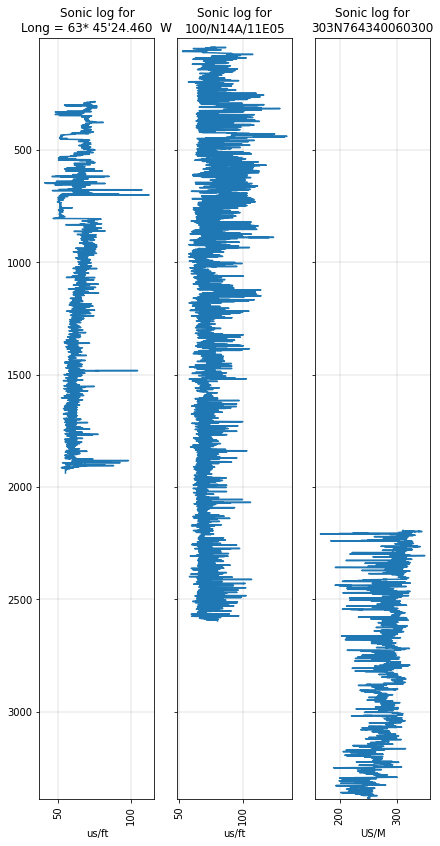

In [10]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize=(7, 14),
                        ncols=len(p),
                        sharey=True,
                        )

for i, (ax, w) in enumerate(zip(axs, p)):
    log = w.get_curve('Sonic', alias=alias)
    if log is not None:
        ax = log.plot(ax=ax)
    ax.set_title("Sonic log for\n{}".format(w.uwi))

min_z, max_z = p.basis_range
    
plt.ylim(max_z, min_z)
plt.show()

## Get a `pandas.DataFrame`

The `df()` method makes a DataFrame using a dual index of UWI and Depth.

Before we export our wells, let's give Kennetcook #2 a better UWI:

In [11]:
p[0].uwi = p[0].name
p[0]

Well(uwi: 'Kennetcook #2', name: 'Kennetcook #2', 24 curves: ['CALI', 'HCAL', 'PEF', 'DT', 'DTS', 'DPHI_SAN', 'DPHI_LIM', 'DPHI_DOL', 'NPHI_SAN', 'NPHI_LIM', 'NPHI_DOL', 'RLA5', 'RLA3', 'RLA4', 'RLA1', 'RLA2', 'RXOZ', 'RXO_HRLT', 'RT_HRLT', 'RM_HRLT', 'DRHO', 'RHOB', 'GR', 'SP'])

That's better.

When creating the DataFrame, you can pass a list of the keys (mnemonics) you want, and use aliases as usual.

In [12]:
alias

{'Sonic': ['DT', 'DT4P'], 'Caliper': ['HCAL', 'CALI']}

In [16]:
keys = ['Caliper', 'GR', 'Sonic']

df = p.df(keys=keys, alias=alias, rename_aliased=True)
df

Caliper             GR     Sonic
UWI              DEPT                                                    
Kennetcook #2    1.0668000000       4.3912849426  46.6986503600       NaN
                 1.2192000000       4.3912849426  46.6986503600       NaN
                 1.3716000000       4.3912849426  46.6986503600       NaN
                 1.5240000000       4.3912849426  46.6986503600       NaN
                 1.6764000000       4.3912849426  46.6986503600       NaN
...                                          ...            ...       ...
303N764340060300 3387.5471999996  303.7090000000  32.0276000039  252.4951
                 3387.6995999996  303.7090000000  32.0276000000  252.4951
                 3387.8519999996  303.7090000000  32.0276000000  252.4951
                 3388.0043999996  303.7090000000  32.0276000000  252.4951
                 3388.1567999996  303.7090000000  32.0276000000  252.4951

[46594 rows x 3 columns]

## Quality

Welly can run quality tests on the curves in your project. Some of the tests take arguments. You can test for things like this:

- `all_positive`: Passes if all the values are greater than zero.
- `all_above(50)`: Passes if all the values are greater than 50.
- `mean_below(100)`: Passes if the mean of the log is less than 100.
- `no_nans`: Passes if there are no NaNs in the log.
- `no_flat`: Passes if there are no sections of well log with the same values (e.g. because a gap was interpolated across with a constant value).
- `no_monotonic`: Passes if there are no monotonic ramps in the log (e.g. because a gap was linearly interpolated across).

Insert lists of tests into a dictionary with any of the following key examples:

- `'GR'`: The test(s) will run against the GR log.
- `'Gamma'`: The test(s) will run against the log matching according to the alias dictionary.
- `'Each'`: The test(s) will run against *every log* in a well.
- `'All'`: Some tests take multiple logs as input, for example `quality.no_similarities`. These test(s) will run against all the logs as a group. Could be quite slow, because there may be a lot of pairwise comparisons to do.

The tests are run against all wells in the project. If you only want to run against a subset of the wells, make a new project for them.

In [11]:
import welly.quality as q

tests = {
    'All': [q.no_similarities],
    'Each': [q.no_gaps, q.no_monotonic, q.no_flat],
    'GR': [q.all_positive],
    'Sonic': [q.all_positive, q.all_between(50, 200)],
}

Let's add our own test for units:

In [12]:
def has_si_units(curve):
    return curve.units.lower() in ['mm', 'gapi', 'us/m', 'k/m3']

tests['Each'].append(has_si_units)

We'll use the same alias dictionary as before:

In [13]:
alias

{'Sonic': ['DT', 'DT4P'], 'Caliper': ['HCAL', 'CALI']}

Now we can run the tests and look at the results, which are in an HTML table:

In [14]:
from IPython.display import HTML

HTML(p.curve_table_html(keys=['Caliper', 'GR', 'Sonic', 'SP', 'RHOB'],
                        tests=tests, alias=alias)
    )

Idx,UWI,Data,Passing,Caliper*,GR,Sonic*,SP,RHOB
,,,%,3/3 wells,3/3 wells,3/3 wells,2/3 wells,3/3 wells
0,Kennetcook #2,5/24 curves,54,HCAL⬤4.39 in,GR⬤78.99 gAPI,DT⬤63.08 us/ft,SP⬤52.47 mV,RHOB⬤2.61 g/cm3
1,100/N14A/11E05,5/18 curves,79,CALI⬤8.90 in,GR⬤103.74 gAPI,DT⬤74.90 us/ft,SP⬤101.60 mV,RHOB⬤2.62 g/cm3
2,303N764340060300,4/22 curves,78,CALI⬤311.97 MM,GR⬤67.49 GAPI,DT4P⬤279.84 US/M,⬤,RHOB⬤2493.56 K/M3


Here's how to interpret the result:

- Green background: the log is present. You can see the mean value and the units (check them!!).
- Grey background: the log is not present.

And the traffic light dots (hover to see how many tests passed): 

- Green dot: all the tests passed.
- Orange dot: some tests failed.
- Red dot: all tests failed.
- Grey dot: no tests ran.

The **Passing** percentage shows how many tests passed for that well.

---

&copy; 2022 Agile Scientific, CC BY